## Keras CNN Exploration

### Load Libraries

In [1]:
import sys
import os
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
import warnings 
warnings.filterwarnings('ignore', category=UserWarning)
sys.path.insert(0, '../../')
from library.notebook_api.data_loader import  ModelDataLoader,CombinedDataLoader
from library.notebook_api.model_loader import ModelScenario

2024-12-07 18:53:45.203630: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load Data
load data from data loader and inspect the shape of the features which appears to be variable

In [2]:
model_data_loader = ModelDataLoader('005')
model_data_loader_df = model_data_loader.df
features = model_data_loader.get_mfcc()
labels_series = model_data_loader.df['label']
#array of feature shapes
feature_shapes = [feature.shape[1] for feature in features]
print("features shape distribution")
print(pd.Series(feature_shapes).value_counts())
print("total records: ", len(features))

features shape distribution
2582    13510
2585    10580
2812      583
1         460
1293      357
        ...  
609         1
490         1
242         1
528         1
873         1
Name: count, Length: 132, dtype: int64
total records:  25947


In [3]:
#verify matching length
len(labels_series) , len(features)

(25947, 25947)

### Define Filter Based on features

In [4]:
# currently filtered to just the most common shapes, as we'll need to normalize shapes prior to training 
MFCC_LENGTH_CUTOFF = 2582
#array of indexes matching a predicate 
in_scope_feature_indexes = np.where(np.array(feature_shapes) >= MFCC_LENGTH_CUTOFF)[0]
print("normalized length: ",len(in_scope_feature_indexes))

normalized length:  24679


### Encode Labels
assign a numerical index to each string label, then one hot encode the label dataset 

In [5]:
labels_series.value_counts()

label
rock                  7305
experimental          4848
electronic            4114
hiphop                3488
folk                  1286
pop                   1038
classical              997
jazz                   653
international          629
instrumental           483
oldtime / historic     373
country                294
spoken                 270
soulrnb                 82
blues                   79
easy listening           8
Name: count, dtype: int64

In [5]:
#pick subset of labels that are more intuitively representative of genre 
#genres like pop which are ambiguous are removed 
in_scope_labels = ['rock', 'electronic', 'hiphop', 'classical', 'jazz','country']
#optain the indexes of label series wher the label is in the list 
in_scope_label_indexes = np.array(
    (labels_series[
                    labels_series
                        .apply(lambda x: True if x in  in_scope_labels else False)
                ]
                        .index
    )
)
gtzan_indexes = np.array(
    (model_data_loader_df[
                    model_data_loader_df['dataset']
                        .apply(lambda x: True if x == 'gtzan' else False)
                ]
                        .index
    )
)

#combine filter for the in scope labels with the same for in scope features 
in_scope_indexes = [index for index in in_scope_label_indexes if index in in_scope_feature_indexes]

print("Row Count after label based filter: ", len(in_scope_label_indexes))
print("Final Row count after label and feature filter: ", len(in_scope_indexes))

Row Count after label based filter:  16851
Final Row count after label and feature filter:  16011


In [6]:
in_scope_label_series = labels_series.iloc[in_scope_indexes]
unique_label_names = in_scope_label_series.unique()
unique_label_count = len(in_scope_label_series.unique())
label_to_int_map = {}
for index, label in enumerate(unique_label_names):
    label_to_int_map[label] = index  


int_to_label_map = {v: k for k, v in label_to_int_map.items()}

#numerical_labels = labels_series.map(label_to_int_map)
numerical_labels = in_scope_label_series.map(label_to_int_map)

encoded_labels = tf.one_hot(indices = numerical_labels.values, depth = len(unique_label_names))

#put to list and reshape again 
#not needed in current implementation
#encoded_labels_array = [label.reshape((unique_label_count,1)) for label in encoded_labels.numpy()]
print("Unique label count: ", unique_label_count)
print("label data count " , len(encoded_labels))

Unique label count:  6
label data count  16011


In [7]:
in_scope_label_series.value_counts()

label
rock          7184
electronic    3899
hiphop        3316
classical      869
jazz           549
country        194
Name: count, dtype: int64

### filter, truncate, reshape features
iterate through the filtered features and build a vector representation appropriate for the CNN input

In [9]:
#truncate to consistent length while reshaping 
reshaped_features = []
feature_array = []
for feature in features[in_scope_indexes]:
    mfcc = [] 
    for vector in feature: 
        mfcc.append(vector[0:MFCC_LENGTH_CUTOFF])
        mfcc_reshaped = np.array(mfcc)
    feature_array.append(mfcc_reshaped)
    reshaped_features.append(mfcc_reshaped.reshape((MFCC_LENGTH_CUTOFF,13,1)))

### Train Test Split

In [10]:
#smote implementation
def get_train_test_data_with_smote(feature_array, numerical_labels, test_size, unique_label_names):
    #instantiate initial split
    X_train_, X_test_, y_train_, y_test_ = train_test_split(np.array(feature_array), np.array(numerical_labels), test_size=test_size, random_state=42, stratify =np.array(numerical_labels) )
    smote = SMOTE(random_state=42)
    
    X_train_balance_index, y_train_balanced = smote.fit_resample(np.array(list(range(0,len(X_train_)))).reshape(-1, 1), y_train_)
    #apply smote to the training data
    X_train = X_train_[np.array(X_train_balance_index.reshape(X_train_balance_index.shape[0]))]
    #rshape
    X_train =X_train.reshape((len(X_train),MFCC_LENGTH_CUTOFF,13,1))

    #encoded training data post smote  post smote
    y_train = np.array(tf.one_hot(indices = y_train_balanced, depth = len(unique_label_names)))

    #to adjust shapes for smote 
    #this should be test 
    X_test = X_test_.reshape(X_test_.shape[0], X_test_.shape[2],X_test_.shape[1],1)

    y_test = np.array(tf.one_hot(indices = y_test_, depth = len(unique_label_names)))
    return X_train, X_test, y_train, y_test
  

In [10]:
#generate train and test with stratification for equal label distribution across train and test 
TEST_SIZE = .2

X_train, X_test, y_train, y_test = train_test_split(np.array(reshaped_features), encoded_labels.numpy(), test_size=TEST_SIZE, random_state=42, stratify =encoded_labels.numpy() )
 
#X_train, X_test, y_train, y_test = get_train_test_data_with_smote(feature_array, numerical_labels, TEST_SIZE,  unique_label_names)



In [12]:
X_train[0:10].shape

(10, 2582, 13, 1)

In [23]:
X_train[0:10][:,:,0,0].shape

(10, 2582)

In [46]:
from imblearn.over_sampling import RandomOverSampler 
import numpy as np 
oversample = RandomOverSampler(sampling_strategy='not majority', random_state = 42)
_ = oversample.fit_resample(X_train[0:1000][:,:,0,0], np.argmax(y_train,axis=1)[0:1000])

In [ ]:
#show y dispersions
#np.argmax(y_train,axis=1)[0:100], np.argmax(y_train,axis=1)[0:100][oversample.sample_indices_]

In [47]:
#unique summary on the lables
np.unique(np.argmax(y_train,axis=1)[0:1000], return_counts=True),


((array([0, 1, 2, 3, 4, 5]), array([203, 458, 243,  31,  12,  53])),)

In [51]:
uniques, counts = np.unique(np.argmax(y_train,axis=1)[0:1000],return_counts=True)

In [ ]:
#can we get additional segments to equivalize minority class
counts/np.sum(counts)

array([0.203, 0.458, 0.243, 0.031, 0.012, 0.053])

In [48]:
np.unique(np.argmax(y_train,axis=1)[0:1000][oversample.sample_indices_], return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([458, 458, 458, 458, 458, 458]))

In [ ]:
oversample

array([1, 0, 2, ..., 1, 1, 2])

In [31]:
X_train[0:10][oversample.sample_indices_]

array([[[[-5.54019348e+02],
         [-3.30050293e+02],
         [-1.94032639e+02],
         ...,
         [-2.71220276e+02],
         [-2.81696472e+02],
         [-2.88056030e+02]],

        [[-2.87539124e+02],
         [-2.86828217e+02],
         [-2.68709167e+02],
         ...,
         [-2.72951813e+02],
         [-2.76644165e+02],
         [-2.90808746e+02]],

        [[-2.95921234e+02],
         [-3.00123383e+02],
         [-2.99455963e+02],
         ...,
         [-9.47229919e+01],
         [-1.10252182e+02],
         [-1.19924538e+02]],

        ...,

        [[ 1.21130886e+01],
         [ 7.72169399e+00],
         [ 3.50044084e+00],
         ...,
         [ 3.81861067e+00],
         [ 3.98255301e+00],
         [ 5.77033043e+00]],

        [[ 7.05148220e+00],
         [ 1.11268520e+01],
         [ 1.61440582e+01],
         ...,
         [ 1.59639969e+01],
         [ 1.17321167e+01],
         [ 1.15658474e+01]],

        [[ 1.41698799e+01],
         [ 1.41284847e+01],
         [

In [11]:
#original split
X_train.shape, y_train.shape

((12808, 2582, 13, 1), (12808, 6))

### Define CNN model

In [18]:
model = keras.Sequential(layers=[
    #https://www.youtube.com/watch?v=dOG-HxpbMSw
    #convulution 1
    keras.layers.Conv2D(32, (3,3), activation=keras.activations.relu),
    keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    #convolution 2
    keras.layers.Conv2D(32, (3,3), activation=keras.activations.relu),
    keras.layers.MaxPooling2D((3,3), strides=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    #convolution 3
    keras.layers.Conv2D(32, (2,2), activation=keras.activations.relu),
    keras.layers.MaxPooling2D((2,2), strides=(2,2), padding='same'),
    keras.layers.BatchNormalization(),
    #flatten and feed into dense layer with dropiut
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=keras.activations.relu),
    keras.layers.Dropout(0.3),
    #predictions
    keras.layers.Dense(unique_label_count, activation=keras.activations.softmax)
        
    ])
cce = keras.losses.categorical_crossentropy

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss=cce, metrics=['accuracy'])

In [187]:
#note this currently only works after training
#To do figure out how to build model prior to training to inspect it's architectuer
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 2580, 11, 32)      320       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 1290, 6, 32)       0         
 ng2D)                                                           
                                                                 
 batch_normalization_18 (Ba  (None, 1290, 6, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_19 (Conv2D)          (None, 1288, 4, 32)       9248      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 644, 2, 32)        0         
 ng2D)                                                           
                                                      

### Train Model

In [19]:
#configuration
#BATCH_SIZE = 128
BATCH_SIZE = 64
#BATCH_SIZE = 32
EPOCHS = 50
#EPOCHS = 2
#EPOCHS = 2

consider stratified k-fold: https://www.kaggle.com/code/chayannaskar26/stratified-k-fold-cnn
Or smote for imbalance

Epoch 1/50
432/432 [==============================] - 537s 1s/step - loss: 1.5778 - accuracy: 0.3407 - val_loss: 3.7327 - val_accuracy: 0.0628
Epoch 2/50
432/432 [==============================] - 554s 1s/step - loss: 1.5059 - accuracy: 0.3890 - val_loss: 3.9696 - val_accuracy: 0.0677
Epoch 3/50
432/432 [==============================] - 406s 940ms/step - loss: 1.4712 - accuracy: 0.4052 - val_loss: 3.7337 - val_accuracy: 0.0345
Epoch 4/50
432/432 [==============================] - 360s 833ms/step - loss: 1.4655 - accuracy: 0.4091 - val_loss: 4.4279 - val_accuracy: 0.0174


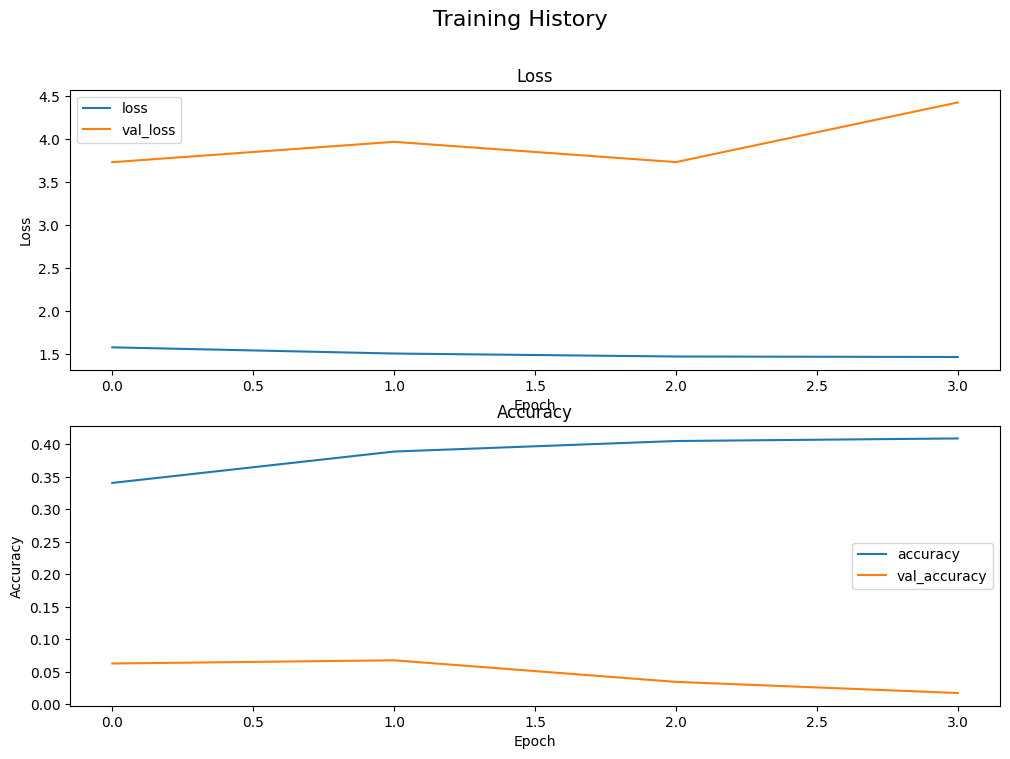

In [15]:
# Train the model
#following reference: https://www.kaggle.com/code/nilshmeier/melspectrogram-based-cnn-classification/notebook
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    #monitor='val_accuracy',
    min_delta = 0,
    patience=3, 
    mode='auto',
    restore_best_weights=True
    )
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

101/101 [==============================] - 14s 136ms/step


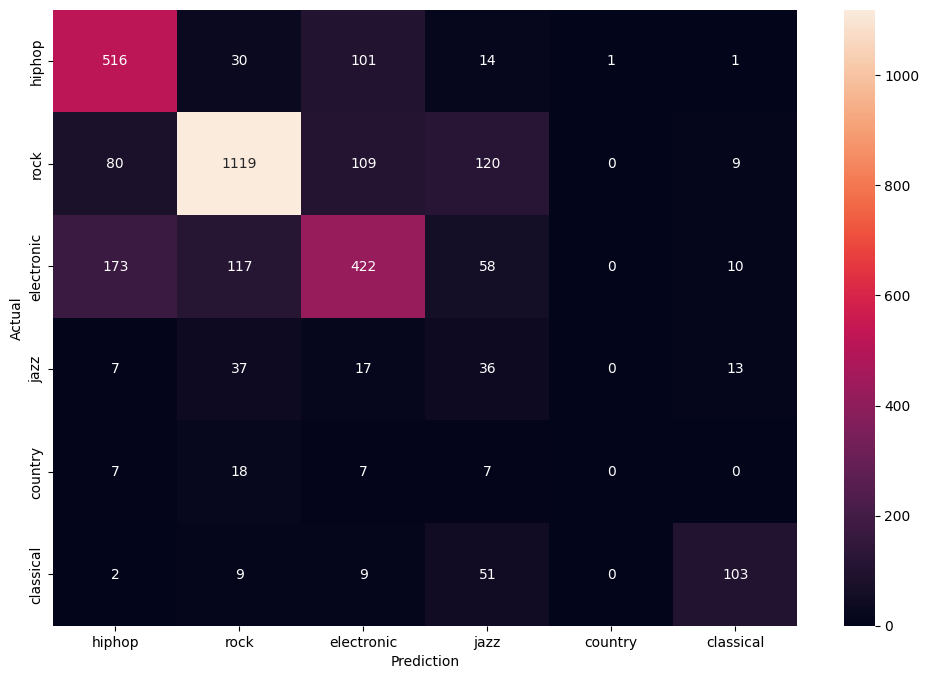

In [16]:
#validation 
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
#remap the ints to string names 
label_names = [int_to_label_map[int_label] for int_label in np.unique(numerical_labels)]
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()